In [2]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter , lfilter
from scipy.fftpack import fft, fftfreq
%matplotlib inline

In [3]:
'''  MODEL PARAMETERS '''

Cm = 100*pF                    # membrane capacitance
g_leak =10*nS                  # leak conductance
E_rest = -65*mvolt             # membrane rest potential
V_thresh = -52*mvolt           # membrane threshold potential
V_reset = -67*mvolt            # membrane reset potential 
tau_m = 10*ms                  # membrane time constant
tau_r = 1*ms                   # absolute refractory period

E_i  = -75*mvolt               # inhib. reversal potential
E_e  =  0*mvolt                # excit. reversal potential

tau_l = 1*ms                   # time delay 
tau_r_e  = 0.5*ms
tau_d_e  = 2*ms
tau_r_i  = 0.45*ms
tau_d_i  = 1.2*ms

g_peak_e = 1*nS
g_peak_i = 5*nS


N_inhib = 200      # number of inhibitory inter neurons in the network
N_excit = 800      # each inter neuron gets input from 800 excit. neurons.


In [4]:
def heaviside(t , t0):
    if t >= t0:
        return 1
    else:
        return 0  

In [5]:
defaultclock.dt = 0.05*ms             # choose a particular time step
timestep = 0.05*ms
input_rate = (5000/N_excit)*Hz       # total input to each neuron is 5 KHz
alpha = 1 /ms

''' ----------  NEURON EQUATIONS ------------- '''

eqs_model = '''
dv/dt = (g_leak*(E_rest - v) + I_syn )/Cm : volt
I_syn = I_ampa_exc + I_rec : amp
I_ampa_exc = g_peak_e*(E_e - v)*s_ampa_tot : amp
I_rec = g_peak_i*(E_i -v)*s_rec_tot : amp
s_ampa_tot : 1
s_rec_tot  : 1
'''

eqs_ampa = '''
s_ampa_tot_post = w * s_ampa : 1 (summed)
ds_ampa / dt = - s_ampa / tau_d_e + alpha * x * (1 - s_ampa) : 1 (clock-driven)
dx / dt = - x / tau_r_e : 1 (clock-driven)
w : 1
'''
eqs_pre_ampa = '''
x += 1
'''
eqs_rec = '''
s_rec_tot_post = w * s_rec : 1 (summed)
ds_rec / dt = - s_rec / tau_d_i + alpha * y * (1 - s_rec) : 1 (clock-driven)
dy / dt = - y / tau_r_i : 1 (clock-driven)
w : 1
'''
eqs_pre_rec = '''
y += 1
'''
#clip(gi, 0, g_peak_i)
P = PoissonGroup(8400, rates=input_rate)

G = NeuronGroup(N_inhib, eqs_model, threshold='v> V_thresh', reset='v = V_reset', method ='euler')

# Excitatory Synapse Group
S_excit = Synapses(P,G, model=eqs_ampa , on_pre= eqs_pre_ampa , delay = tau_l , method = 'euler')
S_excit.connect(p=0.095)
S_excit.w = 1.0
# Inhibitory, Recurrent Synapse Group

S_inhib = Synapses(G,G,model=eqs_rec , on_pre= eqs_pre_rec , delay = tau_l , method = 'euler')
S_inhib.connect(condition='i!=j', p=0.2)
# set inhib weights to 1.0 as well
S_inhib.w = 1.0
# Spike, State Monitors

State_Mon = StateMonitor(G, 'v',record=True)
Spike_Mon = SpikeMonitor(G)
Rate_Mon = PopulationRateMonitor(G)

# initialise at rest 
G.v = E_rest
print('Before v = %s' % G.v[0])
run(200*ms)
print('After v = %s' % G.v[0])

WARNING    c:\users\debap\appdata\local\programs\python\python37\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\debap\.cython\brian_extensions\_cython_magic_977491d6de0534ef6a3a4584a6640019.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Before v = -65. mV
After v = -54.94145031 mV


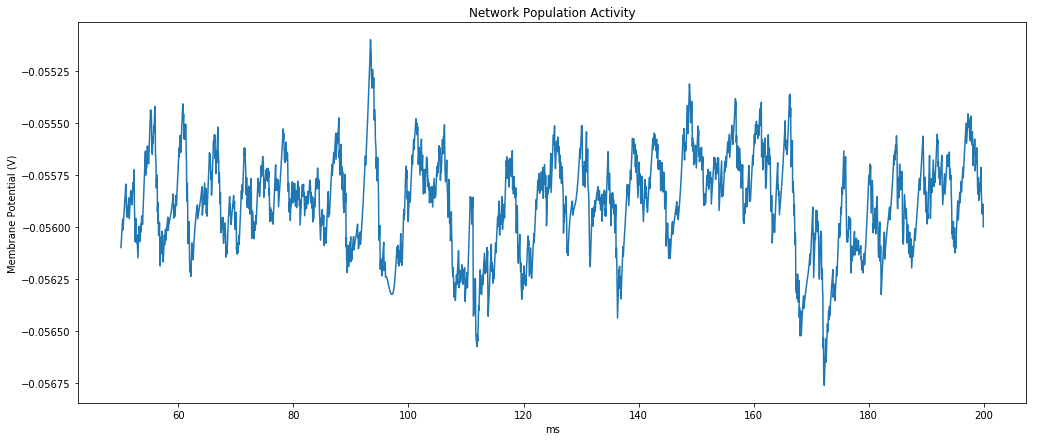

In [6]:
'''
plt.figure(figsize=(17,7))
plot(State_Mon.t[:]/ms, State_Mon.v[np.random.randint(N_inhib)])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Singel Neuron Activity')
plt.show()

plt.figure(figsize=(17,7))
for i in range(5):
    plot(State_Mon.t[:]/ms, State_Mon.v[np.random.randint(N_inhib)][:])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.show()
'''

# Define ROI in time by slicing out the initial bump in voltage artifact which dulls rest of data

T = State_Mon.t[1000:]/ms
v_pop = np.mean(State_Mon.v , axis = 0)[1000:]     # population level average

plt.figure(figsize=(17,7))
plot(T, v_pop )
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Network Population Activity')
plt.show()

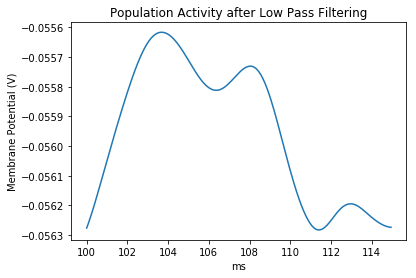

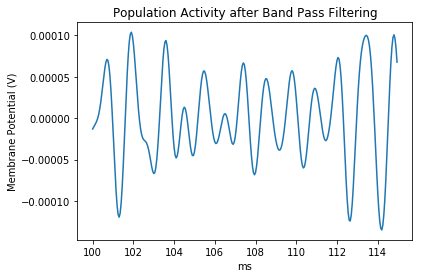

In [17]:
def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = False)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fs  = 5_000

v_lp = butter_lowpass_filter(v_pop, 50, fs)    # low pass filtering 

plot( T[1000:1300], v_lp[1000:1300])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Population Activity after Low Pass Filtering')
plt.show()

v_bp = butter_bandpass_filter(v_pop, lowcut=140 ,highcut=300, fs = fs)

plot( T[1000:1300], v_bp[1000:1300])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Population Activity after Band Pass Filtering')
plt.show()



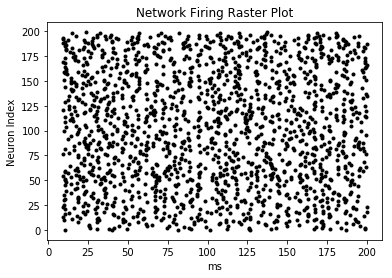

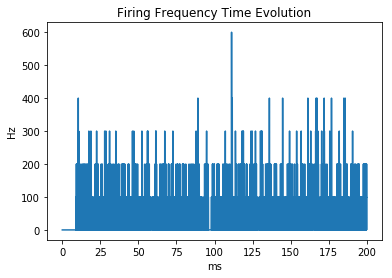

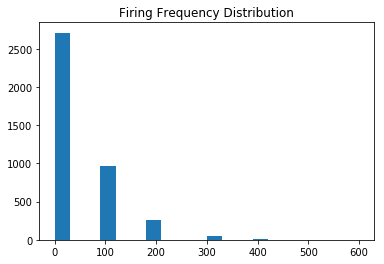

In [14]:
plot(Spike_Mon.t/ms, Spike_Mon.i , '.k')
xlabel('ms')
ylabel('Neuron Index')
plt.title('Network Firing Raster Plot')

figure()
plot(Rate_Mon.t/ms, Rate_Mon.rate/Hz )
plt.title('Firing Frequency Time Evolution')
xlabel('ms')
ylabel('Hz')

plt.show()
plt.hist(Rate_Mon.rate/Hz , bins = 20)
plt.title('Firing Frequency Distribution')
plt.show()

# population spike count vs time --> mean, std, 